In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools as it

from utilities.data_visualizers import view_value_frequency, describe_col, visualize_graph, view_tensor_values, train_cross_results_v2
from utilities.data_preprocessors import get_length__build_value_to_index, normalize_ratings, build_results
from utilities.data_loaders import load_raw_ratings_large, load_raw_kg_20k

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
ml_1m_ratings = load_raw_ratings_large('./data/ml-1m')
ml_1m_ratings

d:\Projects\To Github\phil-jurisprudence-recsys\utilities\data_loaders.py:34: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(f'{dir_path}/ratings.dat', delimiter='::', header=None)


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [88]:
ml_1m_ratings = normalize_ratings(ml_1m_ratings)
ml_1m_ratings

,user_id,item_id,rating,timestamp,avg_rating,normed_rating
0,1,1193,5,978300760,4.390725,0.609275
1,1,661,3,978302109,3.464762,-0.464762
2,1,914,3,978301968,4.154088,-1.154088
3,1,3408,4,978300275,3.863878,0.136122
4,1,2355,5,978824291,3.854375,1.145625
...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,2.793566,-1.793566
1000205,6040,1094,5,956704887,3.731489,1.268511
1000206,6040,562,5,956704746,3.799163,1.200837
1000207,6040,1096,4,956715648,3.976744,0.023256


# userId column

In [89]:
describe_col(ml_1m_ratings, 'user_id')

count/no. of occurences of each unique user_id out of 1000209: 

total unique values: 6040


# itemId column

In [90]:
describe_col(ml_1m_ratings, 'item_id')

count/no. of occurences of each unique item_id out of 1000209: 

total unique values: 3706


# rating column

In [91]:
describe_col(ml_1m_ratings, 'rating')

count/no. of occurences of each unique rating out of 1000209: 

total unique values: 5


In [92]:
user_id_counts = ml_1m_ratings['user_id'].value_counts()
item_id_counts = ml_1m_ratings['item_id'].value_counts()
print(user_id_counts)
print(item_id_counts)

4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
        ... 
5725      20
3407      20
1664      20
4419      20
3021      20
Name: user_id, Length: 6040, dtype: int64
2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
3458       1
2226       1
1815       1
398        1
2909       1
Name: item_id, Length: 3706, dtype: int64


d:\Projects\To Github\phil-jurisprudence-recsys\utilities\data_visualizers.py:95: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data = value_counts.sort_values(ascending=True)[:limit]


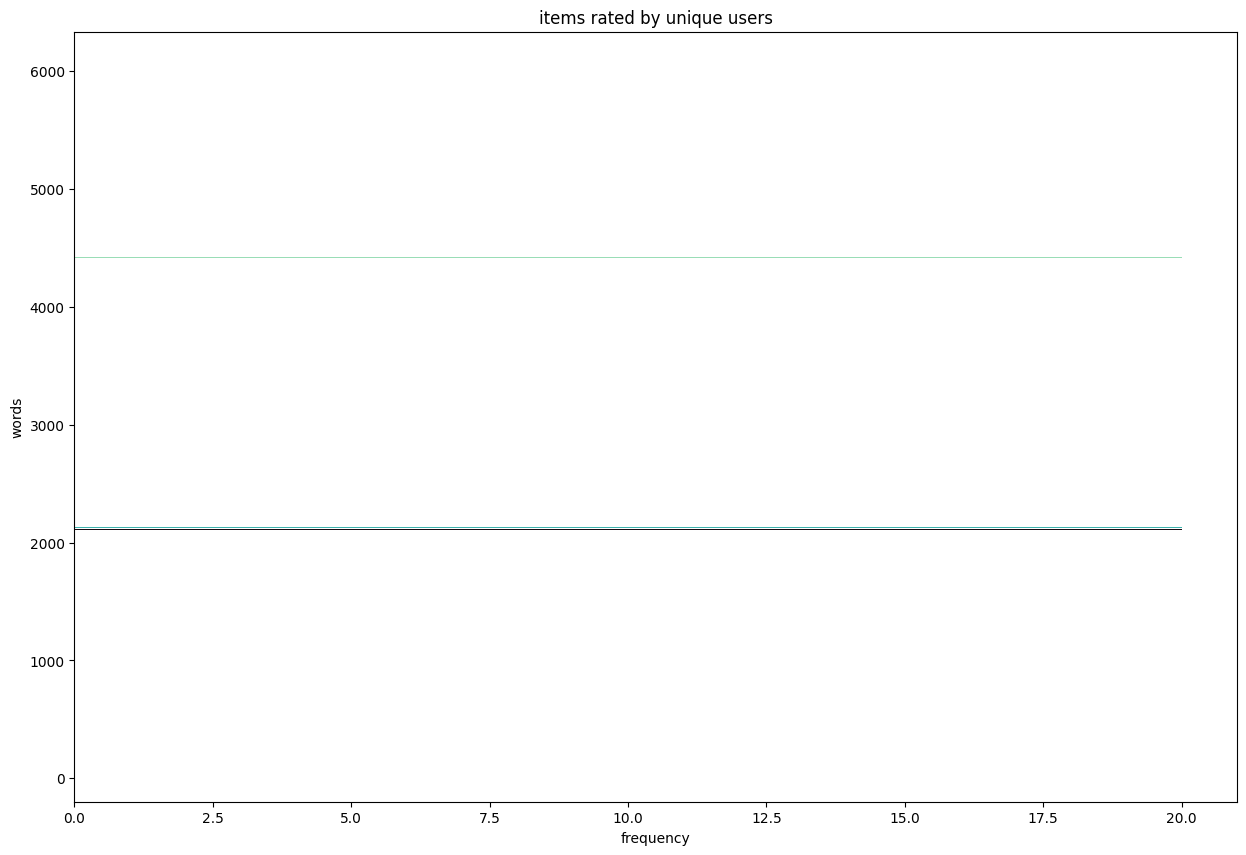

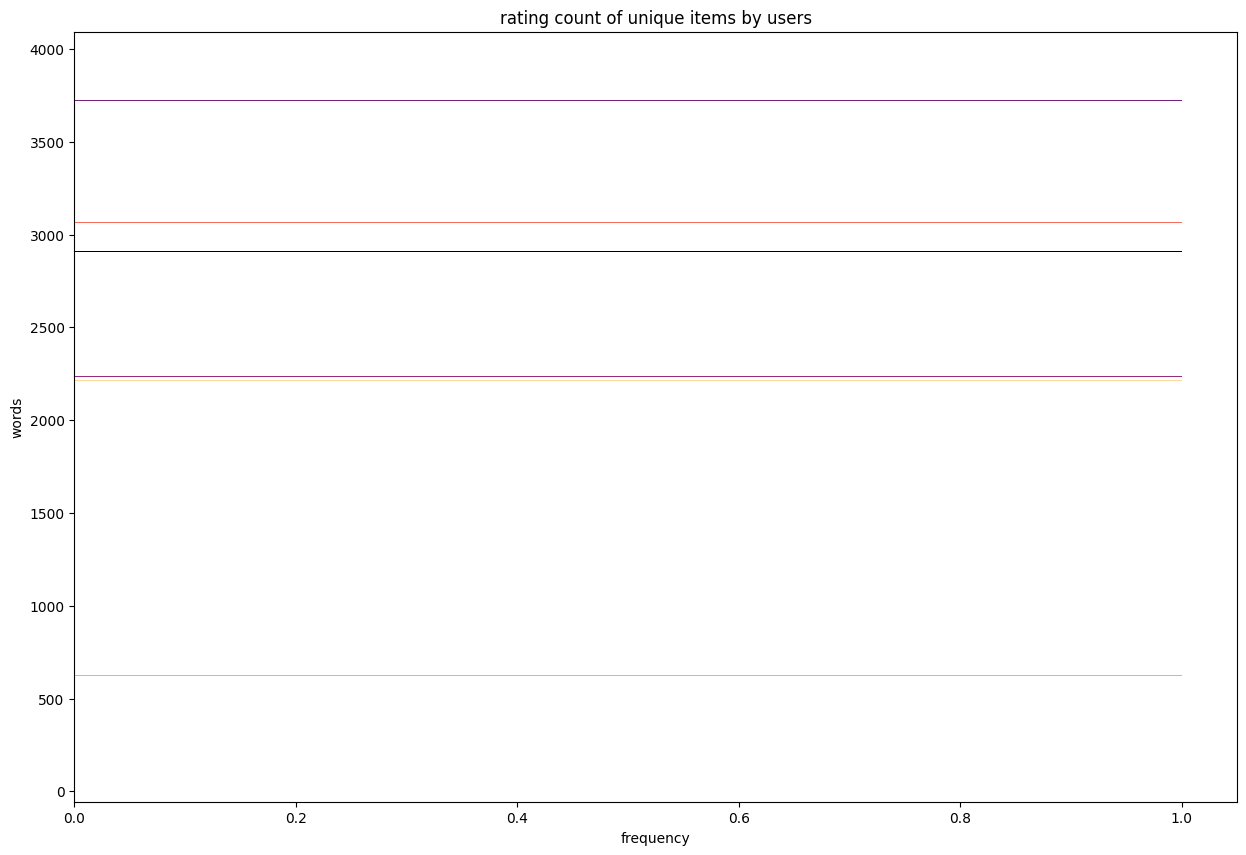

In [93]:
view_value_frequency(user_id_counts, colormap='mako', title='items rated by unique users', limit=50)
view_value_frequency(item_id_counts, colormap='magma', title='rating count of unique items by users', limit=50)

In [94]:
n_users, user_to_index = get_length__build_value_to_index(ratings=ml_1m_ratings, column='user_id')

unique user_id's: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
do unique user_id's have missing user_id's? False
number of unique user_id: 6040
sampled dictionary of all unique user_id mapped to their respective indeces from 0 to |n_u - 1| {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14}


In [95]:
n_items, item_to_index = get_length__build_value_to_index(ratings=ml_1m_ratings, column='item_id')

unique item_id's: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
do unique item_id's have missing item_id's? True
number of unique item_id: 3706
sampled dictionary of all unique item_id mapped to their respective indeces from 0 to |n_i - 1| {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14}


In [96]:
# modify dataframe column user_id with new indeces from 0 to n_u - 1
ml_1m_ratings['user_id'] = ml_1m_ratings['user_id'].apply(lambda user_id: user_to_index[user_id])
ml_1m_ratings['item_id'] = ml_1m_ratings['item_id'].apply(lambda item_id: item_to_index[item_id])

## Testing initial models

In [97]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import MeanSquaredError as mse_loss
from tensorflow.keras.metrics import MeanSquaredError as mse_metric
from tensorflow import GradientTape

## Define architecture of test model
* For the input, since length of user_id is only a scalar. Input would be $(none, 1)$ or $(m, 1)$
* For the user and item embedding layer, we would have embedding matrix of $(n_{users}, 32)$ and $(n_{items}, 32)$ respectively in all training examples this would have shape $(m ,1 ,32)$
* For the user and item embedding bias layer would have embedding matrix of $(n_{users}, 1)$ the same as the learned bias vector *BETA* ($\Beta$) in matrix factorization in all training examples this would have $(m, 1, 1)$
* multiply the user_embedding and item embedding tensors $[0][1][2]$; this is the axis indeces of a 3d tensor so we multiply our $(m, 1, 100)$ user embedding to a $(m, 100, 1)$ transpose of the item embedding in the $[2]$ axis index of our user tensor which is 100 we multiply transpose

In [98]:
# since length of user_id is only a scalar. Input would be None, 1 or m x 1
user_id_input = tf.keras.Input(shape=(1,), dtype=tf.int64, name='user_id')
item_id_input = tf.keras.Input(shape=(1,), dtype=tf.int64, name='item_id')

# user and item embedding layer
user_emb_layer = tf.keras.layers.Embedding(n_users, 32, embeddings_regularizer=L2(1), name='user_embedding')
item_emb_layer = tf.keras.layers.Embedding(n_items, 32, embeddings_regularizer=L2(1), name='item_embedding')

# bias vector embedding layer
user_emb_bias_layer = tf.keras.layers.Embedding(n_users, 1, embeddings_initializer='zeros', name='user_embedding_bias')
item_emb_bias_layer = tf.keras.layers.Embedding(n_items, 1, embeddings_initializer='zeros', name='item_embedding_bias')

# output layers
dot_layer = tf.keras.layers.Dot(axes=(2, 1))
add_layer = tf.keras.layers.Add()

## the ff. defines the forward pass architecture of the inputs of the matrix factorization model

In [99]:
# forward pass
user_emb = user_emb_layer(user_id_input)
item_emb = item_emb_layer(item_id_input)

user_emb_bias = user_emb_bias_layer(user_id_input)
item_emb_bias = item_emb_bias_layer(item_id_input)

# out = tf.linalg.matmul(user_emb, tf.transpose(item_emb, perm=[0, 2, 1])) + user_emb_bias + item_emb_bias
user_item_dot = dot_layer([user_emb, tf.transpose(item_emb, perm=[0, 2, 1])])
out = add_layer([user_item_dot, user_emb_bias, item_emb_bias])

model = tf.keras.Model(inputs=[user_id_input, item_id_input], outputs=out)
model.summary()

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=mse_loss(),
    metrics=[mse_metric()]
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 item_embedding (Embedding)     (None, 1, 32)        118592      ['item_id[0][0]']                
                                                                                                  
 user_embedding (Embedding)     (None, 1, 32)        193280      ['user_id[0][0]']                
                                                                                            

In [100]:
# view embeddings shape
print(user_emb.shape)
print(item_emb.shape)

(None, 1, 32)
(None, 1, 32)


In [101]:
print(view_tensor_values(user_emb))

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 32), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.convert_to_tensor_3'")


In [102]:
# # uses the normalizer function for the ratigns then 
# # restores it after prediction
# history = model.fit(
#     [ml_1m_ratings['user_id'], ml_1m_ratings['item_id']], ml_1m_ratings['normed_rating'],
#     batch_size=1024,
#     epochs=20,
#     validation_split=0.5
# )

In [103]:
# train_cross_results_v2(
#     build_results(history, metrics=['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error']), 
#     history.epoch, img_title='matrix factorization model results'
# )

In [104]:
# # shape of embedding matrix for items
# model.get_weights()[0].shape

In [105]:
# model.get_weights()[1].shape

In [106]:
# for layer, weights in enumerate(model.get_weights()):
#     print(f"layer {layer} shape of weights/coefficients: {weights.shape}")

## Seeing again the architecture of test models
The test models below uses both FM (Factorizatoin Machine) architecture and the DFM (Deep Factorization Machine) architecture respectively. Using self.summary() method of keras' built-in Model class

In [107]:
from models.model_arcs import DFM, FM

In [108]:
fm_model = FM(n_users=n_users, n_items=n_items)
fm_model.build(input_shape=[(None, 1), (None, 1)])

fm_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=mse_loss(),
    metrics=[mse_metric()]
)

In [109]:
fm_model.summary()

Model: "fm_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding (Embedding)  multiple                  193280    
                                                                 
 item_embedding (Embedding)  multiple                  118592    
                                                                 
 user_embedding_bias (Embedd  multiple                 6040      
 ing)                                                            
                                                                 
 item_embedding_bias (Embedd  multiple                 3706      
 ing)                                                            
                                                                 
 dot_14 (Dot)                multiple                  0         
                                                                 
 add_16 (Add)                multiple                  0      

In [110]:
dfm_model = DFM(n_users=n_users, n_items=n_items)
dfm_model.build(input_shape=[(None, 1), (None, 1)])

dfm_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=mse_loss(),
    metrics=[mse_metric()]
)

In [111]:
dfm_model.summary()

Model: "dfm_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding (Embedding)  multiple                  193280    
                                                                 
 item_embedding (Embedding)  multiple                  118592    
                                                                 
 user_embedding_bias (Embedd  multiple                 6040      
 ing)                                                            
                                                                 
 item_embedding_bias (Embedd  multiple                 3706      
 ing)                                                            
                                                                 
 dot_15 (Dot)                multiple                  0         
                                                                 
 add_17 (Add)                multiple                  0     

# Insights:
1. In 1m rows of ratings there are 6040 unique users
2. In 1m rows of ratings there are 3706 unique items that were rated

# Knowledge Graph/Network analysis

In [112]:
# 20782 rows
kg = load_raw_kg_20k('./data/ml1m-kg20k/')
kg

,head,relation,tail
0,749,film.film.writer,2347
1,1410,film.film.language,2348
2,1037,film.film.language,2348
3,1088,film.film.writer,2349
4,1391,film.film.language,2348
...,...,...,...
20777,2308,film.film.writer,4284
20778,869,film.film.language,2348
20779,1953,film.film.genre,2362
20780,2705,film.film.director,5417


In [113]:
describe_col(kg, 'head')

count/no. of occurences of each unique head out of 20782: 

total unique values: 2445


count/no. of occurences of each unique relation out of 20782: 

total unique values: 7


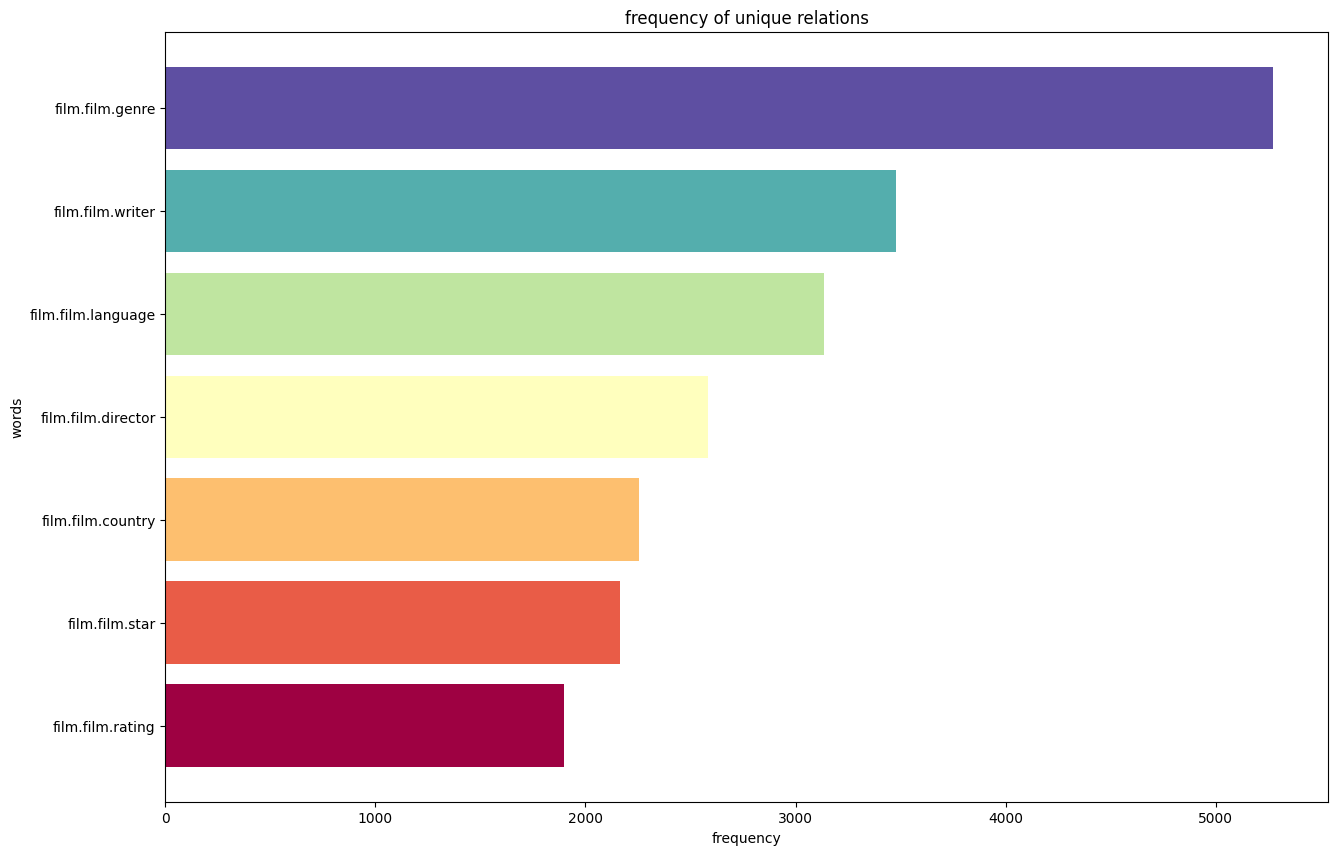

In [114]:
describe_col(kg, 'relation')

relations_count = kg['relation'].value_counts()
view_value_frequency(relations_count, colormap='Spectral', title='frequency of unique relations', limit=relations_count.shape[0])

In [115]:
describe_col(kg, 'tail')

count/no. of occurences of each unique tail out of 20782: 

total unique values: 4563


# Analyze what nodes are connected to who

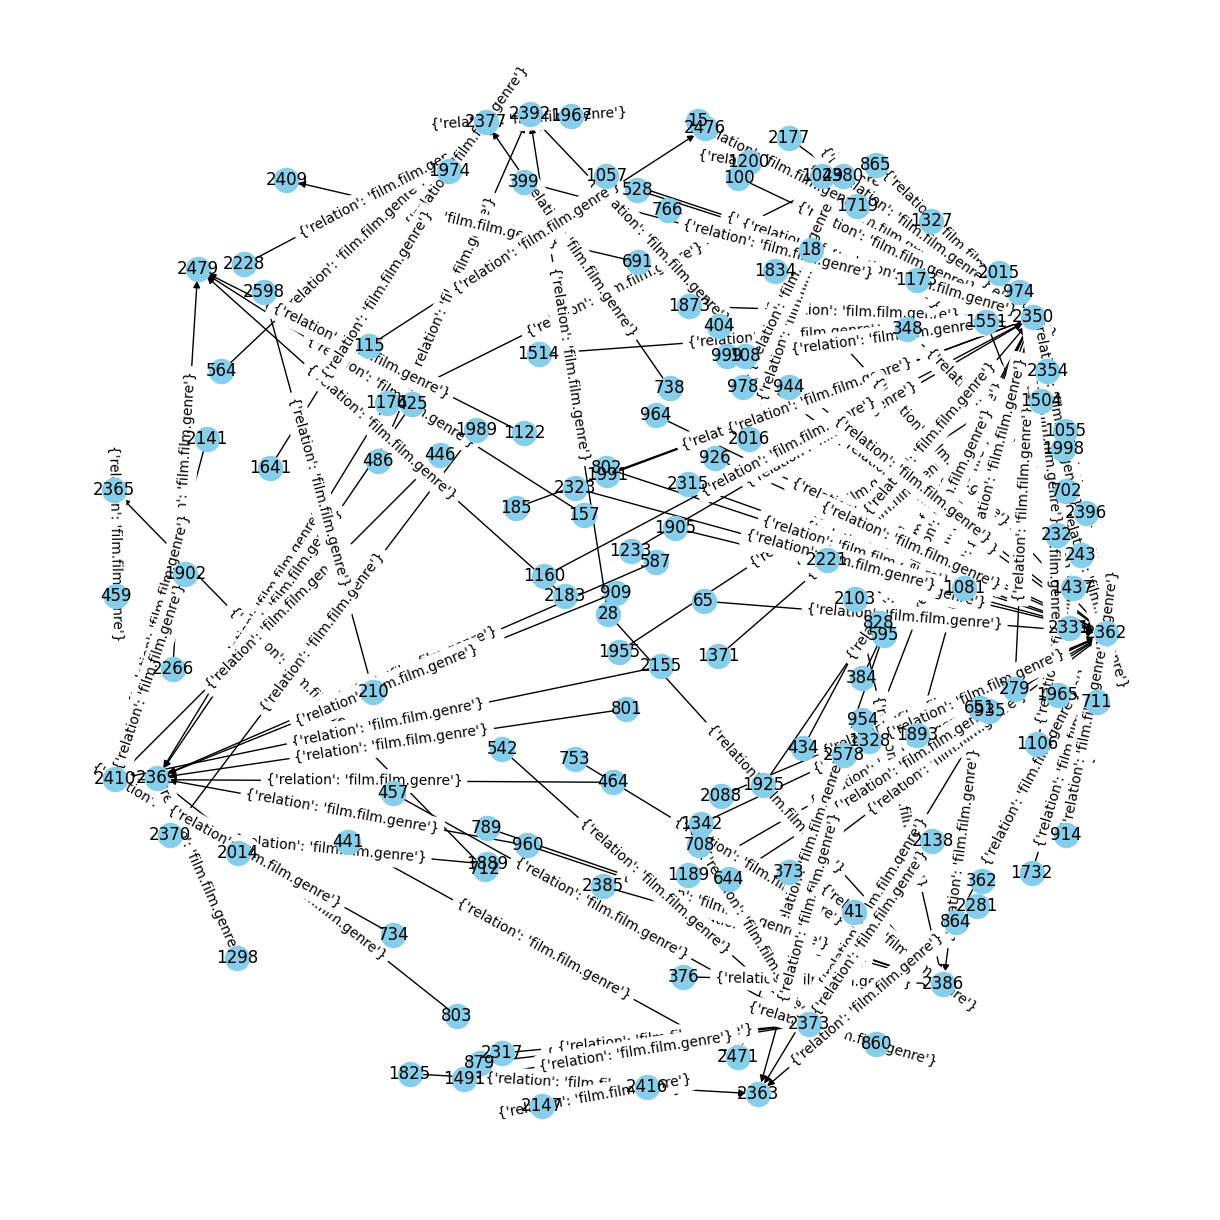

In [116]:
visualize_graph(kg)

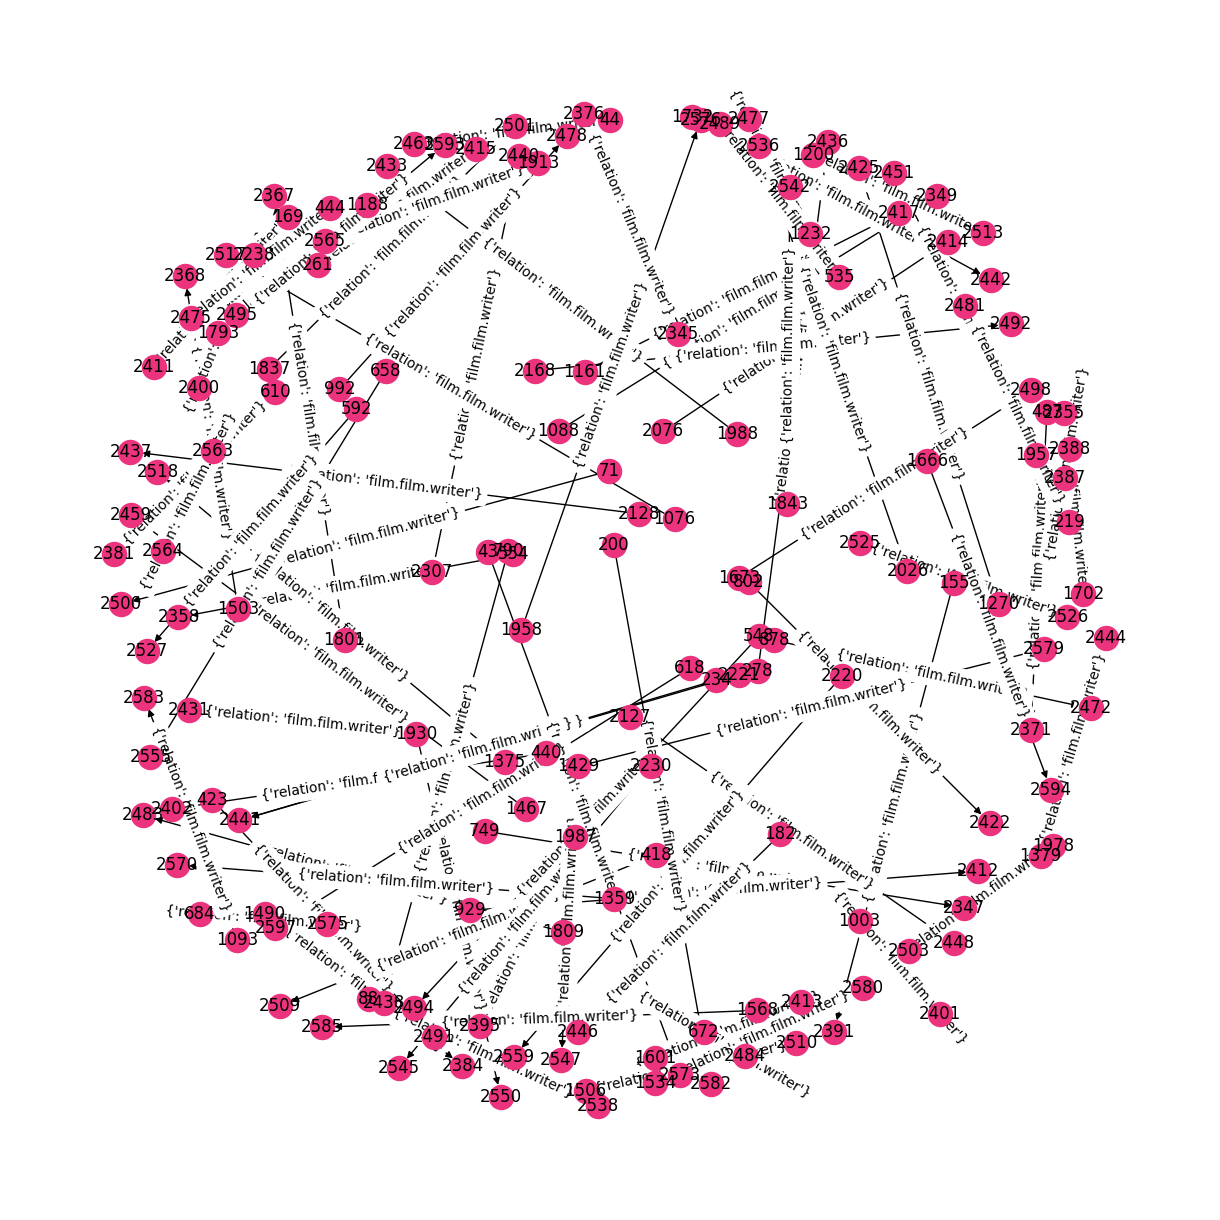

In [117]:
visualize_graph(kg, edge='film.film.writer', node_color='#eb347d')

# Does the head and tail entities appear as an item in the user item interaction data?